# Preparation

In [125]:
# import all the necessary libraries
import os
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.special import expit
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import folium
import statsmodels.api as sm
import scipy.stats
from math import sqrt
import statsmodels.formula.api as smf
from scipy.stats import norm
#read the London population flow file

In [143]:
# 导入所需的库
import pandas as pd


# 读取CSV文件
file_path = 'london_flows.csv'
data = pd.read_csv(file_path)

# 显示数据前几行
print(data.head())

  station_origin station_destination  flows  population   jobs     distance
0     Abbey Road   Bank and Monument      0         599  78549  8131.525097
1     Abbey Road             Beckton      1         599    442  8510.121774
2     Abbey Road           Blackwall      3         599    665  3775.448872
3     Abbey Road        Canary Wharf      1         599  58772  5086.514220
4     Abbey Road        Canning Town     37         599  15428  2228.923167


In [30]:
# 添加对数距离列，确保距离中没有零或负值
data['log_distance'] = np.log(data['distance'] + 1)  # +1 以避免对零取对数
data['log_jobs'] = np.log(data['jobs'] + 1)
data['log_flows'] = np.log(data['flows'] + 1)
# 给距离加上一个小的常数以避免除以零
data['inv_distance'] = np.power(data['distance'] + 0.001, -1)
# 检查是否有缺失值
data.isnull().sum()

station_origin         0
station_destination    0
flows                  0
population             0
jobs                   0
distance               0
log_distance           0
log_jobs               0
log_flows              0
inv_distance           0
dtype: int64

In [153]:
(data0['new_flow']).sum()

99978.83557678136

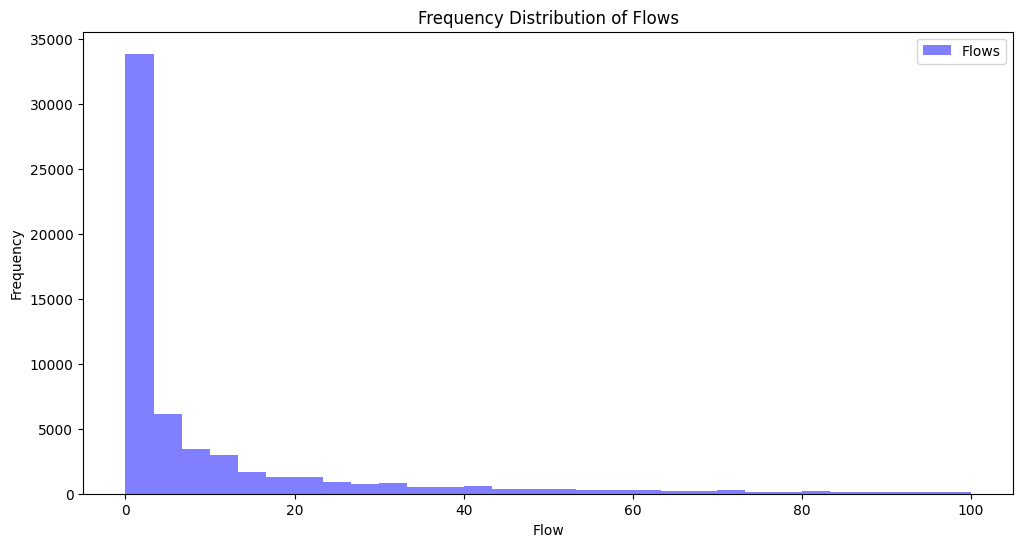

In [127]:
# 绘制原始流量的频率分布图
plt.figure(figsize=(12, 6))
plt.hist(data['flows'], bins=30, alpha=0.5, label='Flows', color='blue', range=(0, 100))


# 添加图例和标签
plt.xlabel('Flow')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Flows')
plt.legend()

In [31]:
#set up the metric calculations
def CalcRSqaured(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    
    return RMSE

# flows - origin

In [32]:
formula = 'flows ~ station_origin + jobs + distance-1'

initial_constrained_model_poisson = smf.glm(formula=formula, data=data, family=sm.families.Poisson()).fit()

print("R-squared: ", CalcRSqaured(data["flows"], initial_constrained_model_poisson.mu))
print("RMSE: ", CalcRMSE(data["flows"], initial_constrained_model_poisson.mu))

R-squared:  0.4061698633533295
RMSE:  101.718


In [33]:
formula = 'flows ~ station_origin + jobs + log_distance-1'

initial_constrained_model_poisson_log = smf.glm(formula=formula, data=data, family=sm.families.Poisson()).fit()

print("R-squared: ", CalcRSqaured(data["flows"], initial_constrained_model_poisson_log.mu))
print("RMSE: ", CalcRMSE(data["flows"], initial_constrained_model_poisson_log.mu))

R-squared:  0.16152789548500204
RMSE:  133.754


In [34]:
formula = 'flows ~ station_origin + jobs + distance-1'

initial_constrained_model_negativebinomial = smf.glm(formula=formula, data=data, family=sm.families.NegativeBinomial()).fit()

print("R-squared: ", CalcRSqaured(data["flows"], initial_constrained_model_negativebinomial.mu))
print("RMSE: ", CalcRMSE(data["flows"], initial_constrained_model_negativebinomial.mu))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


R-squared:  0.16000668029093978
RMSE:  594.361


In [35]:
formula = 'flows ~ station_origin + jobs + log_distance-1'

initial_constrained_model_negativebinomial_log = smf.glm(formula=formula, data=data, family=sm.families.NegativeBinomial()).fit()

print("R-squared: ", CalcRSqaured(data["flows"], initial_constrained_model_negativebinomial_log.mu))
print("RMSE: ", CalcRMSE(data["flows"], initial_constrained_model_negativebinomial_log.mu))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


R-squared:  1.2236149310478477e-06
RMSE:  51317485.603


选择R-squared最大的formula = 'flows ~ station_origin + jobs + distance-1'

In [36]:
formula = 'flows ~ station_origin + jobs + distance-1'

initial_constrained_model_poisson_optimized = smf.glm(formula=formula, data=data, family=sm.families.Poisson()).fit(method='newton', maxiter=100, tol=1e-6)

print("R-squared: ", CalcRSqaured(data["flows"], initial_constrained_model_poisson_optimized.mu))
print("RMSE: ", CalcRMSE(data["flows"], initial_constrained_model_poisson_optimized.mu))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


R-squared:  0.4061698633560388
RMSE:  101.718


In [37]:
# 加入交互项的负二项回归模型
formula = 'flows ~ station_origin + jobs + distance-1'

initial_constrained_model_poisson_interaction = smf.glm(formula=formula, data=data, family=sm.families.Poisson()).fit(method='newton', maxiter=100, tol=1e-6)

print("R-squared: ", CalcRSqaured(data["flows"], initial_constrained_model_poisson_interaction.mu))
print("RMSE: ", CalcRMSE(data["flows"], initial_constrained_model_poisson_interaction.mu))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


R-squared:  0.4061698633560388
RMSE:  101.718


# flows - log

In [38]:
formula = 'log_flows ~ station_origin + jobs + distance-1'

initial_constrained_model_poisson = smf.glm(formula=formula, data=data, family=sm.families.Poisson()).fit()

print("R-squared: ", CalcRSqaured(data["log_flows"], initial_constrained_model_poisson.mu))
print("RMSE: ", CalcRMSE(data["log_flows"], initial_constrained_model_poisson.mu))

R-squared:  0.47260794768468384
RMSE:  1.148


In [39]:
formula = 'log_flows ~ station_origin + jobs + log_distance-1'

initial_constrained_model_poisson_log = smf.glm(formula=formula, data=data, family=sm.families.Poisson()).fit()
print("R-squared: ", CalcRSqaured(data["log_flows"], initial_constrained_model_poisson_log.mu))
print("RMSE: ", CalcRMSE(data["log_flows"], initial_constrained_model_poisson_log.mu))

R-squared:  0.14052907495155695
RMSE:  1.823


In [40]:
formula = 'log_flows ~ station_origin + jobs + distance-1'

initial_constrained_model_negativebinomial = smf.glm(formula=formula, data=data, family=sm.families.NegativeBinomial()).fit()

print("R-squared: ", CalcRSqaured(data["log_flows"], initial_constrained_model_negativebinomial.mu))
print("RMSE: ", CalcRMSE(data["log_flows"], initial_constrained_model_negativebinomial.mu))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


R-squared:  0.37505713984493516
RMSE:  1.512


In [95]:
formula = 'log_flows ~ station_origin + jobs + log_distance-1'

initial_constrained_model_negativebinomial_log = smf.glm(formula=formula, data=data, family=sm.families.NegativeBinomial()).fit()

print("R-squared: ", CalcRSqaured(data["log_flows"], initial_constrained_model_negativebinomial_log.mu))
print("RMSE: ", CalcRMSE(data["log_flows"], initial_constrained_model_negativebinomial_log.mu))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


PatsyError: Error evaluating factor: NameError: name 'log_distance' is not defined
    log_flows ~ station_origin + jobs + log_distance-1
                                        ^^^^^^^^^^^^

In [77]:
data

,station_origin,station_destination,flows,population,jobs,distance,log_distance,log_jobs,log_flows,inv_distance,adjusted_flows,new_flows
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,9.003627,11.271491,0.000000,0.000123,75.683433,4.905852
1,Abbey Road,Beckton,1,599,442,8510.121774,9.049129,6.093570,0.693147,0.000118,15.738036,1.020150
2,Abbey Road,Blackwall,3,599,665,3775.448872,8.236539,6.501290,1.386294,0.000265,21.666638,1.404446
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,8.534545,10.981438,0.693147,0.000197,62.680994,4.063025
4,Abbey Road,Canning Town,37,599,15428,2228.923167,7.709722,9.644004,3.637586,0.000449,32.163353,2.084850
...,...,...,...,...,...,...,...,...,...,...,...,...
61469,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,9.503219,8.114624,4.852030,0.000075,40.413003,2.619598
61470,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,9.071360,8.610319,6.411818,0.000115,57.661142,3.737635
61471,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,9.163010,5.993961,1.945910,0.000105,49.319624,3.196932
61472,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,8.586019,6.795706,4.406719,0.000187,65.793388,4.264772


In [111]:
alpha_i = initial_constrained_model_poisson.params[0:-2]
gamma = initial_constrained_model_poisson.params[-2]
beta = -initial_constrained_model_poisson.params[-1]

/var/folders/rv/j_vzprd56j5fpq5_0hvsy8v80000gn/T/ipykernel_10846/3185961820.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gamma = initial_constrained_model_poisson.params[-2]
/var/folders/rv/j_vzprd56j5fpq5_0hvsy8v80000gn/T/ipykernel_10846/3185961820.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = -initial_constrained_model_poisson.params[-1]


In [144]:
data0 = data

In [154]:
data0.loc[data0['station_destination'] == 'Canary Wharf', 'jobs'] *= 0.5

In [157]:
coefs = pd.DataFrame()
coefs = pd.DataFrame(initial_constrained_model_poisson.params)
coefs.reset_index(inplace=True)
coefs.rename(columns = {0:"alpha_i", "index":"coef"}, inplace = True)
to_repl = ["(station_origin)", "\[", "\]"]
for x in to_repl:
    coefs["coef"] = coefs["coef"].str.replace(x, "",regex=True)
#then once you have done this you can join them back into the dataframes
data0 = data0.merge(coefs, left_on="station_origin", right_on="coef", how = "left")
data0.drop(columns = ["coef"], inplace = True)
#check this has worked
data0.head()

<>:5: SyntaxWarning: invalid escape sequence '\['
<>:5: SyntaxWarning: invalid escape sequence '\]'
<>:5: SyntaxWarning: invalid escape sequence '\['
<>:5: SyntaxWarning: invalid escape sequence '\]'
/var/folders/rv/j_vzprd56j5fpq5_0hvsy8v80000gn/T/ipykernel_10846/4292933020.py:5: SyntaxWarning: invalid escape sequence '\['
  to_repl = ["(station_origin)", "\[", "\]"]
/var/folders/rv/j_vzprd56j5fpq5_0hvsy8v80000gn/T/ipykernel_10846/4292933020.py:5: SyntaxWarning: invalid escape sequence '\]'
  to_repl = ["(station_origin)", "\[", "\]"]


,station_origin,station_destination,flows,population,jobs,distance,alpha_i_x,new_flow,alpha_i_y,alpha_i
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,0.577893,4.905852,0.577893,0.577893
1,Abbey Road,Beckton,1,599,442,8510.121774,0.577893,1.020150,0.577893,0.577893
2,Abbey Road,Blackwall,3,599,665,3775.448872,0.577893,1.404446,0.577893,0.577893
3,Abbey Road,Canary Wharf,1,599,29386,5086.514220,0.577893,4.063025,0.577893,0.577893
4,Abbey Road,Canning Town,37,599,15428,2228.923167,0.577893,2.084850,0.577893,0.577893


In [161]:
data0["log_new_flow"] = np.exp(data0["alpha_i"]+gamma*(data0["jobs"]) - beta*data0["distance"])

In [107]:


data["log_new_flow"] = round(data["log_new_flow"],0)
#now we can convert the pivot table into a matrix
data = data.pivot_table(values ="log_new_flow", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
data

/var/folders/rv/j_vzprd56j5fpq5_0hvsy8v80000gn/T/ipykernel_10846/3369761644.py:5: FutureWarning: The provided callable <function sum at 0x1126aae80> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  data = data.pivot_table(values ="log_new_flow", index="station_origin", columns = "station_destination",
/var/folders/rv/j_vzprd56j5fpq5_0hvsy8v80000gn/T/ipykernel_10846/3369761644.py:5: FutureWarning: The provided callable <function sum at 0x1126aae80> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  data = data.pivot_table(values ="log_new_flow", index="station_origin", columns = "station_destination",
/var/folders/rv/j_vzprd56j5fpq5_0hvsy8v80000gn/T/ipykernel_10846/3369761644.py:5: FutureWarning: The provided callable <function sum at 0x1126

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,47.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,97.0
Acton Town,NaN,NaN,NaN,2.0,1.0,NaN,3.0,0.0,NaN,2.0,...,2.0,2.0,1.0,3.0,NaN,0.0,NaN,1.0,NaN,409.0
Aldgate,NaN,NaN,1.0,NaN,2.0,NaN,NaN,0.0,NaN,2.0,...,1.0,NaN,1.0,1.0,NaN,1.0,NaN,1.0,NaN,226.0
Aldgate East,NaN,NaN,1.0,3.0,NaN,NaN,1.0,0.0,NaN,2.0,...,1.0,1.0,1.0,1.0,NaN,1.0,NaN,1.0,NaN,350.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,1.0,2.0,3.0,NaN,NaN,NaN,NaN,2.0,...,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,387.0
Woodgrange Park,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.0
Woodside Park,NaN,NaN,1.0,2.0,2.0,NaN,1.0,NaN,NaN,2.0,...,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,318.0


In [108]:
data0['log_old_flow'] = np.log(data0['flows'] + 1)

In [162]:
data0['log_new_flow'].sum()


99381.32938607752

In [164]:
np.log(data0['flows']+1).sum()


99978.83557698817

In [64]:
round(new_flows)

0        5.0
1        1.0
2        1.0
3        4.0
4        2.0
        ... 
61469    3.0
61470    4.0
61471    3.0
61472    4.0
61473    3.0
Length: 61474, dtype: float64

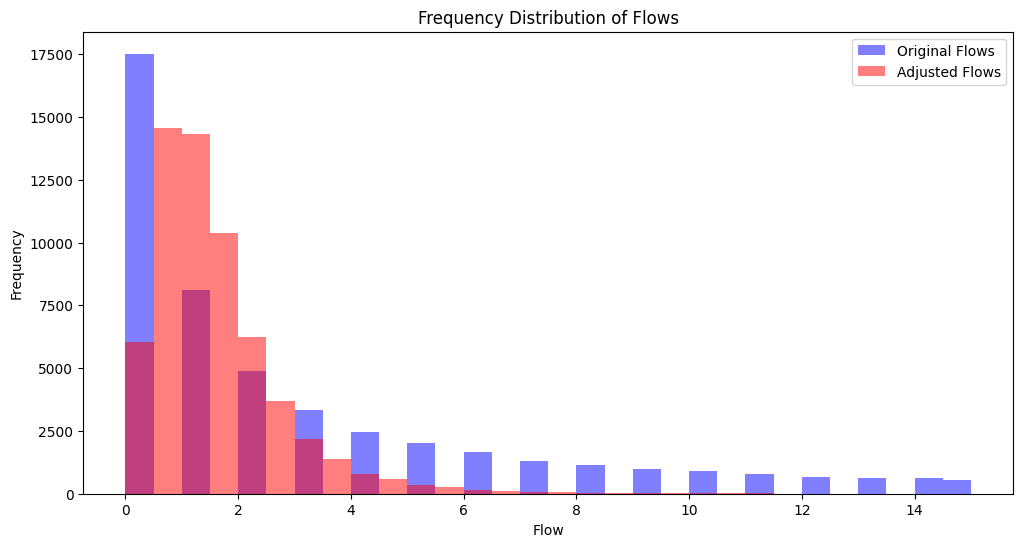

In [74]:
# 绘制原始流量的频率分布图
plt.figure(figsize=(12, 6))
plt.hist(data['flows'], bins=30, alpha=0.5, label='Original Flows', color='blue', range=(0, 15))

# 绘制调整后的流量的频率分布图
plt.hist(data['new_flows'], bins=30, alpha=0.5, label='Adjusted Flows', color='red', range=(0, 15))

# 添加图例和标签
plt.xlabel('Flow')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Flows')
plt.legend()

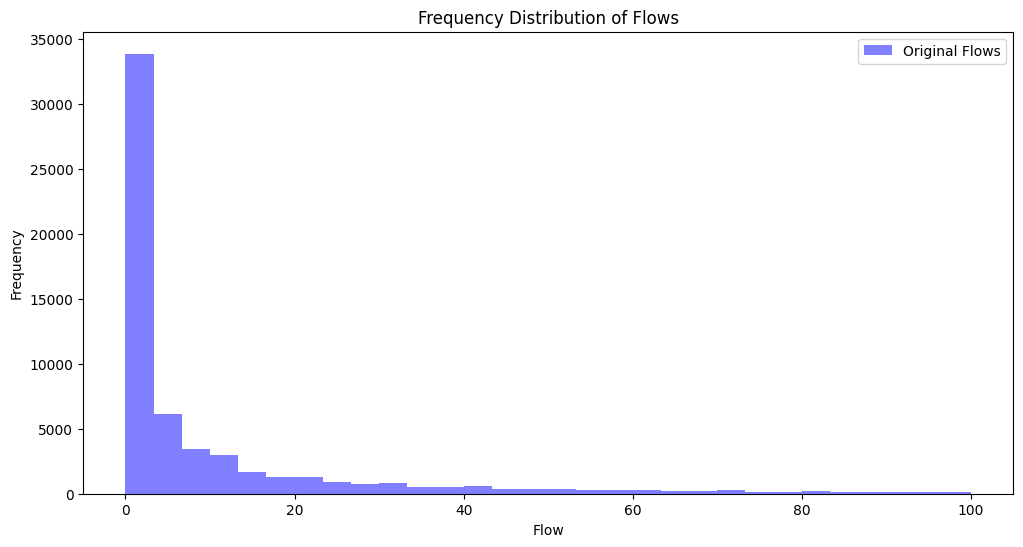

In [71]:
# 绘制原始流量的频率分布图
plt.figure(figsize=(12, 6))
plt.hist(data['flows'], bins=30, alpha=0.5, label='Original Flows', color='blue', range=(0, 100))


# 添加图例和标签
plt.xlabel('Flow')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Flows')
plt.legend()

58772